1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


Mean: 0.016889255179510298
Std: 1.0124030074254269


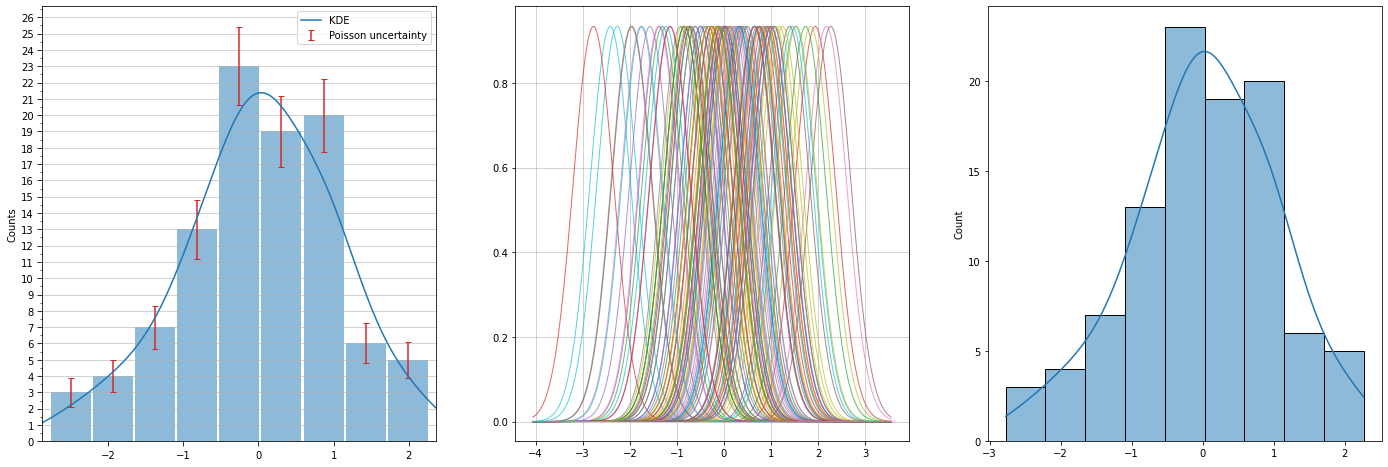

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.ticker import MultipleLocator
from scipy.integrate import trapezoid
import math as m
import seaborn as sns

%matplotlib inline

N = 100
mu, sigma = 0, 1
x = sigma*np.random.randn(N)+mu

print('Mean:', x.mean())
print('Std:', x.std())

fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1, ncols = 3, figsize=(24, 8))

n, bins, _ = ax0.hist(x, bins='auto', alpha=0.5, rwidth=0.95, color='C0')
# n, bins, _ = ax0.hist(x, bins=(np.linspace(x.min(), x.max(), int(m.sqrt(N)))), alpha=0.7, rwidth=0.9)
ax0.set_ylabel('Count')
ax0.grid(axis='y', alpha=0.7)
ax0.set_xlim(left = bins[0]-0.1, right=bins[-1]+0.1)

ax0.yaxis.set_major_locator(MultipleLocator(1))
ax0.yaxis.set_minor_locator(MultipleLocator(0.5))
ax0.tick_params(which='major', length=5)

bin_centers = 0.5*(bins[1:] + bins[:-1])

ax0.errorbar(bin_centers, n, yerr=np.sqrt(n)/2, ls='none', label='Poisson uncertainty', ecolor='C3', capsize=3, lolims=0)

# --------------------------------------------------------------------------------------------------

xstd = 1.06 * x.std() * x.size**(-1/5.)
xplot = np.linspace(-3*xstd+min(x), 3*xstd+max(x), 200)

gauss_funcs = np.array(norm.pdf(xplot, loc=x[0], scale=xstd),)
for mean in x[1:]:
    gauss_funcs = np.vstack((gauss_funcs, norm.pdf(xplot, loc=mean, scale=xstd)))

ax1.plot(xplot, gauss_funcs.T, lw=1, alpha=0.7);
ax1.grid(alpha=0.7)

gauss_sum = np.sum(gauss_funcs, axis=0)
hist_int = np.sum([(bins[i+1]-bins[i])*n[i] for i in range(len(n))])
gauss_norm = gauss_sum*hist_int/trapezoid(gauss_sum, xplot)

ax0.plot(xplot, gauss_norm, lw=1.5, color='C0', label='KDE')
ax0.legend(loc='best');


# --------------------------------------------------------------------------------------------------
# SEABORN
ax2 = sns.histplot(x, kde=True)

# TODO: labels, title, poisson uncertainty


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [ ]:
# ! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot